04/22 to 
KF + ML

1. flag_prior = False
2. x=[p_x,v_x,p_y,v_y]，全部检查一遍
3. Q 按照paper书写
4. ML estimator 的prior 为 Fx_t-1

问题：
1. 自从改了Q以后，kf+ml比ml差了很多(注意原来Q不能完全适用，因为状态里的顺序变了)。考虑也可能是ML的prior是Fxt-1，是最佳的，不具有最好参考意义。
2. prior_std之前为0.5（一点几倍lmb），现在按照wavelength倍数设置，暂时设置为0.5lmb或者lmb
3. q改到很小后(0.001),KF_ML 比ML好；其他情况都明显更差，而且在后期很可能偏离。

04/30
1. 按照Phase noisedB进行了实验，非常奇怪,kf+ml 随着noise增大，结果更好。
2. 试着在04_22看一下是不是类似情况1.(无法实现，因为KF，gene_tr等python文件已经更改)
3. 尝试把KF+ML的R_ml改成R，MSE会更小一点（尤其是noise偏小的时候）
4. 多多尝试不同的noise_std

下一步:
1. 实施EKF
2. 多多尝试不同的ml_resol
3. 检查一遍。思考为什么出现这种情况。

In [32]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy.random as rd
from filterpy.kalman import ExtendedKalmanFilter
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import pandas as pd
import seaborn as sns



from gene_tr import Calcphases,array,GenerateTraj
from ML_estimator import ML
from Evaluation import *
from KF import *
from Basic import *

In [33]:
# ML parameters
f=8.6e8
lmb = 3e8/f
print(f'ML parameters: f:{f},lmb:{lmb})'
#array
N=10 # number of elements
d=0.25*lmb # distance between 2 adjacent elements
arr_dim=d*(N-1) # dimension of the array
arr=array(N,arr_dim,0) # array elements location

ML parameters: f:860000000.0,lmb:0.3488372093023256,ml_resol:0.6976744186046512


# Generate trajectories data and store

1. 这里不考虑phases，只考虑生成trajectories.
2. Split datasets. 

In [34]:

#generate N_tr trajectories and store the data

N_tr=50 #number of trajectories
Length=200 #length of a trajectory
dt=0.1

#trajectory parameters-1d
F_1 = np.array([[1, dt], [0, 1]])
H_1=np.array([1,0])  
q=0.001
Q_1 =  (q**2)*np.array([[(dt**3)/3,(dt**2)/2],[(dt**2)/2,dt]]) 
r=1
R_1 = r**2  # position observation noise

# #trajectory parameters-2d
zero_2_2=np.zeros([2,2])
zero_1_2=np.zeros([1,2])
F = np.block([[F_1,zero_2_2],[zero_2_2,F_1]])
H = np.block([[H_1,zero_1_2],[zero_1_2,H_1]])
Q = np.block([[Q_1,zero_2_2],[zero_2_2,Q_1]])
R = np.block([[R_1,0],[0,R_1]])

#Generate trajectories and save them in a  txt file
real_states=np.zeros((N_tr,Length,4))
position_measurements=np.zeros((N_tr,Length,2))
for i in range (N_tr):
    #initial position
    x_start=np.random.uniform(3,5,1).squeeze()
    y_start=np.random.uniform(4,6,1).squeeze()
    X0=np.array([0,x_start,0,y_start]).reshape(4,1)
    r_s, p_m= GenerateTraj(Length,dt,X0,H,F,Q,R)
    r_s=r_s.reshape(Length,4)
    p_m=p_m.reshape(Length,2)
    real_states[i,:,:] = r_s
    position_measurements[i,:,:] = p_m
with open('trajectories_states.txt', 'w') as outfile:
    for slice_2d in real_states:
        np.savetxt(outfile, slice_2d, fmt = '%f', delimiter = ',')
with open('trajectories_measurements.txt', 'w') as outfile:    
    for slice_2d in position_measurements:
        np.savetxt(outfile, slice_2d, fmt = '%f', delimiter = ',')


real_states= np.loadtxt('trajectories_states.txt', delimiter = ',').reshape((N_tr, Length, 4))

# Use the training set to estimate MSE of encoder. 

In [35]:
def Estimate_MLencoder_MSE(num_train,Length,states_train,Phases_train,H,F,prior_std,arr,lmb,ml_resol):
    ML_output=np.empty([num_train,Length,2])
    for i in range(num_train):
        real_states_i=states_train[i,:,:].reshape(Length,4,1)
        Phases_i = Phases_train[i,:,:]
        
        for j in range(Length):
            #synthetic prior
            if(j==0):
                prior_mean=np.zeros(2)
            else:
                prior_mean=H@(F@states_train[i,j-1,:]) #Fx_t-1
            #search space: synthetic prior
            xrange_p=np.array([prior_mean[0]-3*prior_std,prior_mean[0]+3*prior_std])
            yrange_p=np.array([prior_mean[1]-3*prior_std,prior_mean[1]+3*prior_std])
            
            y_k=Phases_i[j,:]
            ml=ML()
            num_grid,Loc_MLgrid=ml.ML_grid(xrange_p,yrange_p,y_k,arr,lmb,resolution=ml_resol,flag_prior=False,flag_plot=False)
            ML_output[i,j]=Loc_MLgrid.reshape(2) 
    #compute MSE for x position and y position
    ML_output_x=ML_output[:,:,0].reshape([num_train,Length,1])
    ML_output_y=ML_output[:,:,1].reshape([num_train,Length,1])
    states_train_x=states_train[:,:,0].reshape([num_train,Length,1])
    states_train_y=states_train[:,:,2].reshape([num_train,Length,1])


    MSE_x_mean,MSE_x_std=evaluate(states_train_x,ML_output_x)
    MSE_y_mean,MSE_y_std=evaluate(states_train_y,ML_output_y)
    # print(f'MSE_x_mean:{MSE_x_mean},MSE_x_std:{MSE_x_std}')
    # print(f'MSE_y_mean:{MSE_y_mean},MSE_y_std:{MSE_y_std}')

    R_ML=np.array([[MSE_x_mean,0],[0,MSE_y_mean]])
    print(f'R_ML:{R_ML}')
    return R_ML

# EXP1: EF+ML/ML

In [36]:
figsize=(3,2)

In [37]:
def plot_example_Exp1(real_states,filter_result,ML_output_test,dt,flag_save):
    
    plt.figure(figsize=figsize)
    # plt.scatter(np.arange(1*dt,len(measurements)*dt,dt), measurements[1:,0], label = 'Measurements',c='r',s=10)
    plt.plot(np.arange(1*dt,len(real_states)*dt,dt), real_states[1:,0], label = 'Ground truth',c='g' ,linewidth=1)
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,0], label = 'Kalman Filter + ML encoder',c='b',linestyle='--',linewidth=1)
    plt.plot(np.arange(1*dt,len(ML_output_test)*dt,dt), ML_output_test[1:,0], label = 'ML estimator',c='black',linestyle='-',linewidth=1)
    plt.xlabel('Time [s]',fontsize=14)
    plt.ylabel('x-position [m]',fontsize=14)
    plt.legend()
    # plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_10/Tracking_Exp1_Result_px.png')
    # plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_10/Tracking_Exp1_Result_px.eps',format='eps') 

    plt.figure(figsize=figsize)
    plt.plot(np.arange(1*dt,len(real_states)*dt,dt), real_states[1:,1], label = 'Ground truth',c='g' ,linewidth=1)
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,1], label = 'Kalman Filter + ML encoder',c='b',linestyle='--',linewidth=1)
    plt.xlabel('Time [s]',fontsize=14)
    plt.ylabel('x-velocity [m/s]',fontsize=14)
    plt.legend()
    # plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_10/Tracking_Exp1_Result_vx.png')
    # plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_10/Tracking_Exp1_Result_vx.eps',format='eps') 

    plt.figure(figsize=figsize)
    plt.plot(np.arange(1*dt,len(real_states)*dt,dt), real_states[1:,2], label = 'Ground truth',c='g' ,linewidth=1)
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,2], label = 'Kalman Filter + ML encoder',c='b',linestyle='--',linewidth=1)
    plt.plot(np.arange(1*dt,len(ML_output_test)*dt,dt), ML_output_test[1:,1], label = 'ML estimator',c='black',linestyle='-',linewidth=1)
    plt.xlabel('Time [s]',fontsize=14)
    plt.ylabel('y-position [m]',fontsize=14)
    plt.legend()
    # plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_10/Tracking_Exp1_Result_py.png')
    # plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_10/Tracking_Exp1_Result_py.eps',format='eps') 

    plt.figure(figsize=figsize)
    plt.plot(np.arange(1*dt,len(real_states)*dt,dt), real_states[1:,3], label = 'Ground truth',c='g',linewidth=1)
    plt.plot(np.arange(1*dt,len(filter_result)*dt,dt), filter_result[1:,3], label = 'Kalman Filter + ML encoder',c='b',linestyle='--',linewidth=1)
    plt.xlabel('Time [s]',fontsize=14)
    plt.ylabel('y-velocity [m/s]',fontsize=14)
    plt.legend()
    # plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_10/Tracking_Exp1_Result_vy.png')
    # plt.savefig('C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_10/Tracking_Exp1_Result_vy.eps',format='eps') 



In [38]:
def Exp1(num_test,states_test,Length,dt,F,H,Q,R_ML,lmb,ml_resol,prior_std,arr,Phases_test,flagplot):
    EF_ML_output=np.empty([num_test,Length,4])
    ML_output_test=np.empty([num_test,Length,2])
    for i in range(num_test):
        
        #generate phases
        real_states_i=states_test[i,:,:].reshape(Length,4,1)
        Phases_i = Phases_test[i,:,:]
        
        #EXP1-1:EF+ML
        #init
        x0_KF = real_states_i[0,:,:].reshape(4,1)
        P0_KF=np.zeros([4,4])#initial state fully known

        z_i,filter_result_i = KF_ML(Length=Length,dt=dt,x0=x0_KF,P0=P0_KF,F=F,H=H,Q=Q,R=R_ML, #here! R should be replaced by the MSE of ML encoder
                                                    lmb=lmb,ml_resol=ml_resol,std=prior_std,arr=arr,Phases=Phases_i)
        

        EF_ML_output[i]=filter_result_i

        
        #EXP1-2:ML
        #synthetic prior
        for j in range(Length):
            if(j==0):
                prior_mean=np.zeros(2)
            if(j>=1):
                prior_mean=H@(F@states_test[i,j-1,:]) #Fx_t-1
            #search space: synthetic prior
            xrange_p=np.array([prior_mean[0]-3*prior_std,prior_mean[0]+3*prior_std])
            yrange_p=np.array([prior_mean[1]-3*prior_std,prior_mean[1]+3*prior_std])
            
            y_k=Phases_i[j,:]
            ml=ML()
            num_grid,Loc_MLgrid=ml.ML_grid(xrange_p,yrange_p,y_k,arr,lmb,resolution=ml_resol,flag_prior=False,flag_plot=False)
            ML_output_test[i,j]=Loc_MLgrid.reshape(2) 

        if(i==0 and flagplot==True):
            plot_example_Exp1(real_states_i,filter_result_i,ML_output_test[i],dt,flag_save=False)
    
    
    # EF_ML_MSE_mean,EF_ML_MSE_std=evaluate(states_test,EF_ML_output)
    # print(f'EF_ML_MSE_mean:{EF_ML_MSE_mean}')

    states_test_xy=np.stack([states_test[:,:,0],states_test[:,:,2]],axis=2)
    EF_ML_output_xy=np.stack([EF_ML_output[:,:,0],EF_ML_output[:,:,2]],axis=2)
    EF_ML_MSE_xy_mean,EF_ML_MSE_xy_std=evaluate(states_test_xy,EF_ML_output_xy)
    print(f'EF_ML_MSE_xy_mean:{EF_ML_MSE_xy_mean}')

    ML_MSE_xy_mean,ML_MSE_xy_std=evaluate(states_test_xy,ML_output_test)
    print(f'ML_MSE_xy_mean:{ML_MSE_xy_mean}')

    return EF_ML_MSE_xy_mean,ML_MSE_xy_mean

In [39]:
def GeneratePhasesfromtrajectories(N_tr,Length,arr,lmb,phase_offset,phase_noise_std):
    N=arr.shape[0]
    Phases=np.empty([N_tr,Length,N])
    for i in range(N_tr):
        real_positions_i=np.array([real_states[i,:,0],real_states[i,:,2]]).T
        Phases[i,:,:]=Calcphases(real_positions_i,arr,lmb,phase_offset,phase_noise_std)
    return Phases

In [40]:
def Noise_scaledB_to_linear(noise_scale_dB,lmb):
    noise_std_linear=np.empty(len(noise_scale_dB))
    for i in range(len(noise_scale_dB)):
        noise_std_linear[i] = math.pow(10,(-noise_scale_dB[i]/20))/lmb
    return noise_std_linear

ml estimator searching std is 1.0 wavelength
Phase_noise_std:0.2866666666666667
R_ML:[[0.59042772 0.        ]
 [0.         0.64786402]]
EF_ML_MSE_xy_mean:0.0007607249852036805
ML_MSE_xy_mean:0.6762168343217907
Phase_noise_std:0.028666666666666667
R_ML:[[0.27744743 0.        ]
 [0.         0.34948602]]
EF_ML_MSE_xy_mean:0.0010225333439388626
ML_MSE_xy_mean:0.4143457510885568
Phase_noise_std:0.0028666666666666667
R_ML:[[0.12655457 0.        ]
 [0.         0.13969694]]
EF_ML_MSE_xy_mean:0.010302813432214184
ML_MSE_xy_mean:0.1841128115653014
Phase_noise_std:0.0002866666666666667
R_ML:[[0.12655448 0.        ]
 [0.         0.13969672]]
EF_ML_MSE_xy_mean:0.01451331897982409
ML_MSE_xy_mean:0.13914949640697255
Phase_noise_std:2.8666666666666668e-05
R_ML:[[0.12655431 0.        ]
 [0.         0.14018358]]
EF_ML_MSE_xy_mean:0.014203497327964321
ML_MSE_xy_mean:0.13063141515075255


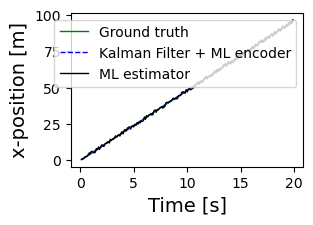

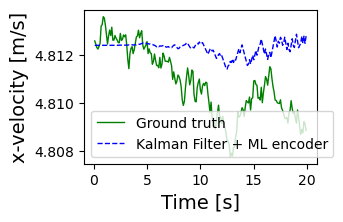

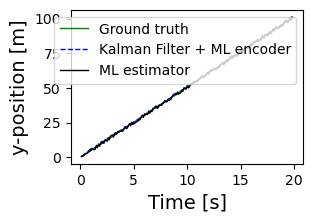

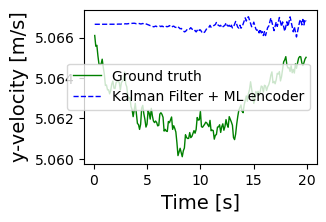

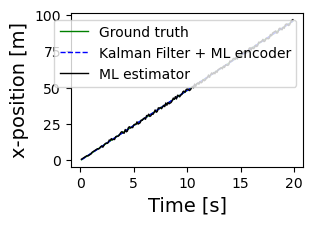

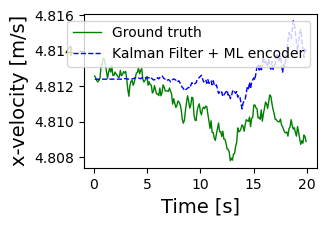

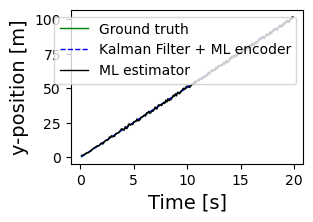

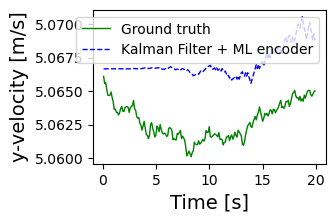

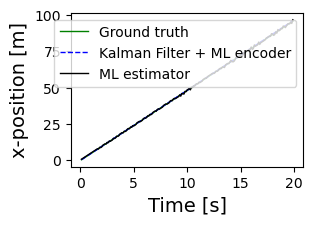

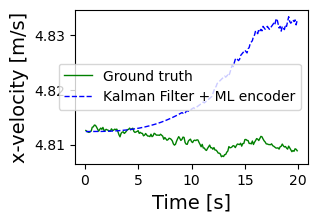

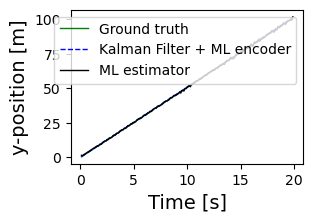

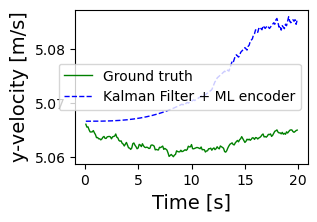

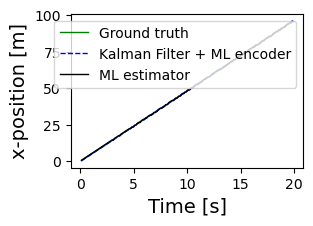

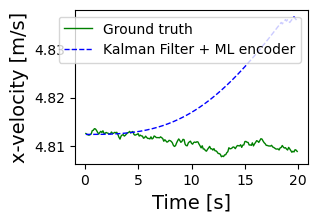

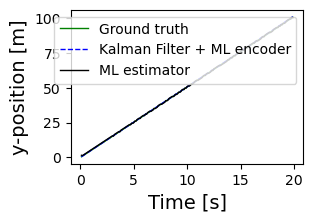

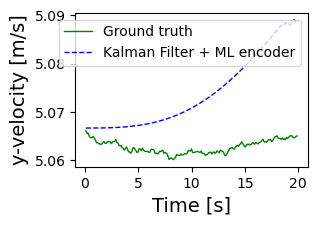

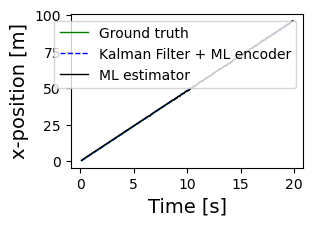

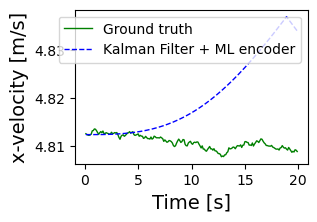

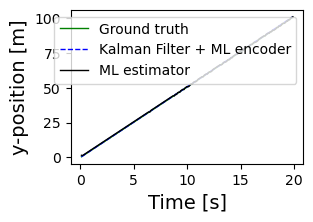

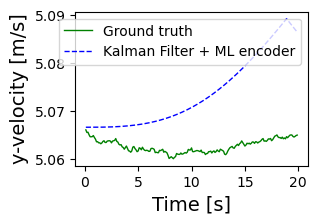

In [82]:
prior_std=1*lmb
print(f'ml estimator searching std is {prior_std/lmb} wavelength')
phase_offset=0
ml_resol=2*lmb

Phases_noise_scale_dB=np.array([20,40,60,80,100])
Phase_noise_std=Noise_scaledB_to_linear(Phases_noise_scale_dB,lmb)

EF_ML_MSE_xy_mean=np.empty(len(Phase_noise_std))
ML_MSE_xy_mean=np.empty(len(Phase_noise_std))
for i in range(len(Phase_noise_std)):
    print(f'Phase_noise_std:{Phase_noise_std[i]}')
    #generate phases
    Phases=GeneratePhasesfromtrajectories(N_tr,Length,arr,lmb,phase_offset,Phase_noise_std[i])
    #split the data into training set and test set
    num_train=int(0.2*N_tr);num_test=N_tr-num_train
    Phases_train=Phases[0:num_train,:,:];Phases_test=Phases[num_train:,:,:]
    states_train = real_states[0:num_train,:,:];states_test = real_states[num_train:,:,:]
        
    R_ML=Estimate_MLencoder_MSE(num_train,Length,states_train,Phases_train,H,F,prior_std,arr,lmb,ml_resol)
    EF_ML_MSE_xy_mean[i],ML_MSE_xy_mean[i] = Exp1(num_test,states_test,Length,dt,F,H,Q,R_ML,lmb,ml_resol,prior_std,arr,Phases_test,flagplot=True)

In [83]:
EF_ML_MSE_xy_mean_scale=EF_ML_MSE_xy_mean/(lmb**2)  #scale according to wavelenth
EF_ML_MSE_mean_dB=todB(EF_ML_MSE_xy_mean_scale)
ML_MSE_xy_mean_scale=ML_MSE_xy_mean/(lmb**2) 
ML_MSE_xy_mean_dB=todB(ML_MSE_xy_mean_scale)

In [84]:
def plot_result_EXP1(Phases_noise_scale_dB,EF_ML_MSE_mean_dB,ML_MSE_xy_mean_dB):
    plt.figure(figsize=figsize)
    plt.plot(Phases_noise_scale_dB,EF_ML_MSE_mean_dB,'+-',label=r'KF+ML',c='blue')
    plt.plot(Phases_noise_scale_dB,ML_MSE_xy_mean_dB,'*--',label=r'ML',c='red')
   
    plt.legend(bbox_to_anchor=(1, 1.15),ncol=3)

    plt.xlabel(r'$σ^{-2}$ [dB]')
    plt.ylabel(r'MSE $\hat{u}$ [dB]')
    plt.grid()


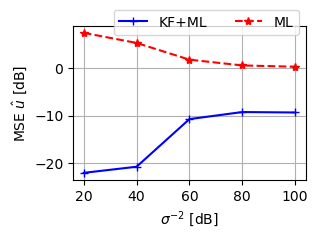

In [85]:
plot_result_EXP1(Phases_noise_scale_dB,EF_ML_MSE_mean_dB,ML_MSE_xy_mean_dB)